# Feature selection in several related datasets with the multitask lasso

In this notebook we consider a mulitask setting in which each task has its own set of samples (and conversely, each sample has a single label).

This problem can be turned into a sparse group lasso problem by creating a new design matrix and coupling all copies of the same features. 

Data: 
* $k$ tasks, $n_r$ samples per task
* same features $j=1, \dots, p$
* data $(X^1, y^1), \dots, (X^k, y^k)$ with $X^r \in \mathbb{R}^{n_r \times p}$ and $y^r \in \{0, 1\}^{n_r}$

Multitask lasso:
$\min_{W \in \mathbb{R}^{p \times k}, b \in \mathbb{R}^k}
\sum_{r=1}^k L(y_i^r, W_{.r}^\top x_i^r + b_r) + \lambda 
\sum_{j=1}^p \lvert\lvert W_{j.} \lvert\lvert_2$

Reformulation:
* $n = \sum_{r=1}^k n_r$
* $X \in \mathbb{R}^{n \times (kp)}$ block-diagonal, with the $X^r$ forming the blocks:
$X = \begin{bmatrix}
        X^1 & 0 & \dots & 0 \\
        0 & X^2 & \dots & 0 \\
        \vdots & \vdots & \vdots & \vdots \\
        0 & 0 & 0 & X^k
    \end{bmatrix}$
* $y \in \{0, 1\}^n$: $y = \begin{pmatrix}
        y^1 \\
        y^2 \\
        \vdots \\
        y^n
        \end{pmatrix}$

This can now be solved as a \textbf{single-task group lasso} with $p$ groups of $k$ features each (group $j$ is made of $k$ copies of the $j$-th feature):
$ \min_{w \in \mathbb{R}^{kp}, b \in \mathbb{R}}
\sum_{i=1}^n L(y_i, w^\top \tilde{x}_i + b) + \lambda 
\sum_{j=1}^p \lvert\lvert w_j \lvert\lvert_2$
 where
* $\tilde{x}_i$ is the $i$-th line of the large matrix $X$ defined above. $x_i \in \mathbb{R}^{kp}$, with $(k-1)p$ zeros and the rest is the actual features of sample $i$.
* $w = (w_1, w_2, \dots, w_p)$ and each $w_j \in \mathbb{R}^k$. The $k$ components of $w_j$ are the coefficients of feature $j$ in each of the $k$ tasks.

This works because the part of $w$ that is not about task $r$ will be multiplied by 0 so whatever values $w$ takes on the other tasks won't affect the loss.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# 1. Regression 

## 1.1 Simulation data
We have here a very simple simulation design (more samples than features, rather high signal-to-noise ration) to test possibilities.

In [ ]:
n_tasks = 3
n_features = 20
n_samples_per_task = [30, 30, 40]
n_samples = np.sum(n_samples_per_task)

n_causal_features = 5 # first n_causal_features have non-zero weights

epsilon = 0.3 # noise level

In [ ]:
causal_weights_per_task = np.zeros(shape=(n_tasks, n_features))

for r in range(n_tasks):
    causal_weights_per_task[r, :n_causal_features] = np.random.random(size=(n_causal_features,))

In [ ]:
for r in range(n_tasks):
    plt.scatter(np.arange(n_features), causal_weights_per_task[r, :], label=('task %s' % r))
plt.legend()

In [ ]:
X = np.zeros((n_samples, n_features))
y = np.zeros((n_samples, ))
start_idx = 0
end_idx = 0 
for r in range(n_tasks):
    end_idx += n_samples_per_task[r]
    X[start_idx:end_idx, :] = np.random.random(size=(n_samples_per_task[r], n_features))    
    y[start_idx:end_idx] = np.dot(X[start_idx:end_idx, :], causal_weights_per_task[r]) + \
        epsilon * np.random.random(size=(n_samples_per_task[r], )) # noise
    start_idx += n_samples_per_task[r]

In [ ]:
start_idx = 0
end_idx = 0 
for r in range(n_tasks):
    end_idx += n_samples_per_task[r]
    plt.scatter((np.dot(X[start_idx:end_idx, :], causal_weights_per_task[r])), y[start_idx:end_idx], label=('task %d' % r))
    start_idx += n_samples_per_task[r]
t = plt.title("Signal-to-noise ratio")
t = plt.xlabel(r"Without noise ($\langle w, x\rangle$)")
t = plt.ylabel(r"With noise ($y = \langle w, x\rangle + \epsilon$)")

## 1.2 Separate single-task lassos on each task with sklearn
Let's consider our 3 tasks separately and run a lasso.

In [ ]:
from sklearn import linear_model

In [ ]:
single_task_lasso_coefs = np.zeros(shape=(n_tasks, n_features))

In [ ]:
from sklearn import model_selection

In [ ]:
param_grid = {'alpha': np.logspace(-5, -2, num=100)}

In [ ]:
lasso_gs = model_selection.GridSearchCV(linear_model.Lasso(), param_grid)

In [ ]:
single_task_lasso_coefs = np.zeros(shape=(n_tasks, n_features))

In [ ]:
start_idx = 0
end_idx = 0 
for r in range(n_tasks):
    end_idx += n_samples_per_task[r]
    # fit lasso
    lasso_gs.fit(X[start_idx:end_idx, :], y[start_idx:end_idx])
    
    # obtain coefficients
    single_task_lasso_coefs[r, :] = lasso_gs.best_estimator_.coef_
    
    # obtain lambda
    print("Best lambda for task %d: %s" % (r, lasso_gs.best_params_))
    
    start_idx += n_samples_per_task[r]

In [ ]:
fig = plt.figure(figsize=(11, 3))
for r in range(n_tasks):
    # create a subplot in the (r+1) position of a 1x3 grid
    ax = fig.add_subplot(1, 3, (r+1))
    
    plt.scatter(np.arange(n_features), causal_weights_per_task[r, :], marker='+', label='true weights')
    
    plt.scatter(np.arange(n_features), single_task_lasso_coefs[r, :], marker='x', label='predicted weights')
    
    plt.legend()
    
    ax.set_title(('task %s' % r))
fig.tight_layout(pad=1.0)

## 1.3 Separate single-task lassos on each task with spams
Here the goal is to make sure to understand spams's syntax on the same problem as above.

In [ ]:
import spams

### With a fixed value of lambda, on the first task

In [ ]:
r = 0
start_idx = 0
end_idx = 0 
end_idx += n_samples_per_task[r]
X_asfa = np.asfortranarray(X[start_idx:end_idx, :])
y_asfa = np.asfortranarray(y[start_idx:end_idx].reshape((n_samples_per_task[r], 1)))
w_init = np.zeros((n_features, 1), order="F")
print(X_asfa.shape, y_asfa.shape, w_init.shape)
w1 = spams.fistaFlat(y_asfa, X_asfa, W0=w_init, 
                    loss='square', regul='l1', 
                    lambda1=10)
w2 = spams.fistaFlat(y_asfa, X_asfa, W0=w_init, 
                    loss='square', regul='l1', 
                    lambda1=1e-3)

In [ ]:
w1 = w1.reshape((w1.shape[0], ))
w2 = w2.reshape((w2.shape[0], ))

In [ ]:
plt.scatter(np.arange(n_features), causal_weights_per_task[r, :], marker='+', label='true features')
plt.scatter(np.arange(n_features), w1, marker='x', label='predicted features, lambda=10.')
plt.scatter(np.arange(n_features), w2, marker='x', label='predicted features, lambda=1e-3')
plt.legend()   

### Turn it into a scikit-learn estimator
In order to use `sklearn.model_selection` we need to turn this into an estimator. 
Help from https://scikit-learn.org/stable/developers/develop.html and https://sklearn-template.readthedocs.io/en/latest/user_guide.html

In [ ]:
from sklearn import base
from sklearn.utils import validation 

In [ ]:
from sklearn.utils import estimator_checks

In [ ]:
class MySpamsLasso(base.BaseEstimator, base.RegressorMixin):
    """
    This class implements a lasso (l1-regularized linear regression) that is fitted using SPAMS.
    """
    def __init__(self, lambda1=1.):
        self.lambda1 = lambda1
                 
    def fit(self, X, y):     
        # Check that X and y have correct shape
        X, y = validation.check_X_y(X, y)
        
        self.X_ = X
        self.y_ = y     
                
        # Fitting 
        X_asfa = np.asfortranarray(self.X_)
        y_asfa = np.asfortranarray(self.y_.reshape((self.y_.shape[0], 1)))
        w_init = np.zeros((X_asfa.shape[1], 1), order="F")

        w = spams.fistaFlat(y_asfa, X_asfa, W0=w_init, lambda1=self.lambda1, regul='l1', loss='square')
        self.coef_ = w.reshape((w.shape[0], ))

        # Return the classifier
        return self
    
    def predict(self, X):
        # Check that fit has been called
        validation.check_is_fitted(self) 
        
        # Input validation
        X = validation.check_array(X)
        
        # Prediction
        return np.dot(X, self.coef_)

In [ ]:
# estimator_checks.check_estimator(MySpamsLasso())

### Using spams within scikit-learn

In [ ]:
param_grid = {'lambda1': np.logspace(-2, 2, num=100)}

In [ ]:
lasso_gs = model_selection.GridSearchCV(MySpamsLasso(), param_grid)

In [ ]:
single_task_lasso_coefs = np.zeros(shape=(n_tasks, n_features))

In [ ]:
start_idx = 0
end_idx = 0 
for r in range(n_tasks):
    end_idx += n_samples_per_task[r]
    # fit lasso
    lasso_gs.fit(X[start_idx:end_idx, :], y[start_idx:end_idx])
    
    # obtain coefficients
    single_task_lasso_coefs[r, :] = lasso_gs.best_estimator_.coef_
    
    # obtain lambda
    print("Best lambda for task %d: %s" % (r, lasso_gs.best_params_))
    
    start_idx += n_samples_per_task[r]

In [ ]:
fig = plt.figure(figsize=(11, 3))
for r in range(n_tasks):
    # create a subplot in the (r+1) position of a 1x3 grid
    ax = fig.add_subplot(1, 3, (r+1))
    
    plt.scatter(np.arange(n_features), causal_weights_per_task[r, :], marker='+', label='true features')
    
    plt.scatter(np.arange(n_features), single_task_lasso_coefs[r, :], marker='x', label='predicted features')
    
    plt.legend()
    
    ax.set_title(('task %s' % r))
fig.tight_layout(pad=1.0)

## 1.4 Turning the problem into a sparse group lasso problem
Now we're ready to move to solving the 3 tasks together in a mulittask formulation.

### New design matrix

In [ ]:
X_mt = np.zeros((n_samples, n_features*n_tasks))
start_idx = 0
end_idx = 0 
for r in range(n_tasks):
    end_idx += n_samples_per_task[r]
    
    X_mt[start_idx:end_idx, r*n_features:(r+1)*n_features] = X[start_idx:end_idx, :]
    
    start_idx += n_samples_per_task[r]

In [ ]:
plt.imshow(X_mt, cmap='viridis', aspect='equal')
plt.colorbar()

### Group membership vector

In [ ]:
groups = np.array([(1+x) for r in range(n_tasks) for x in np.arange(n_features)], dtype=np.int32)

## 1.5 Using spams's group lasso (with fixed regularization parameters)

In [ ]:
X_mt_FA = np.asfortranarray(X_mt)
y_FA = np.asfortranarray(y.reshape(y.shape[0], 1))

In [ ]:
w_initialization = np.zeros((X_mt_FA.shape[1], y_FA.shape[1]), order="F")

In [ ]:
print(X_mt_FA.shape, y_FA.shape, w_initialization.shape, groups.shape)

In [ ]:
w = spams.fistaFlat(y_FA, X_mt_FA, W0=w_initialization, loss='square', regul='group-lasso-l2', groups=groups, lambda1=0.1)

In [ ]:
fig = plt.figure(figsize=(11, 3))
for r in range(n_tasks):
    # create a subplot in the (r+1) position of a 1x3 grid
    ax = fig.add_subplot(1, 3, (r+1))
    
    plt.scatter(np.arange(n_features), causal_weights_per_task[r, :], marker='+', label='true weights')
    
    plt.scatter(np.arange(n_features), w[r*n_features:(r+1)*n_features], marker='x', label='predicted weights')
    
    plt.legend()
    
    ax.set_title(('task %s' % r))
fig.tight_layout(pad=1.0)

### Using a sparse design matrix

In [ ]:
from scipy import sparse

In [ ]:
X_sparse = sparse.csc_matrix(X_mt)

In [ ]:
w = spams.fistaFlat(y_FA, X_sparse, W0=w_initialization, loss='square', regul='group-lasso-l2', groups=groups, lambda1=0.1)

In [ ]:
fig = plt.figure(figsize=(11, 3))
for r in range(n_tasks):
    # create a subplot in the (r+1) position of a 1x3 grid
    ax = fig.add_subplot(1, 3, (r+1))
    
    plt.scatter(np.arange(n_features), causal_weights_per_task[r, :], marker='+', label='true weights')
    
    plt.scatter(np.arange(n_features), w[r*n_features:(r+1)*n_features], marker='x', label='predicted weights')
    
    plt.legend()
    
    ax.set_title(('task %s' % r))
fig.tight_layout(pad=1.0)

### Turn it into a scikit-learn estimator

In [ ]:
class MySpamsGroupLasso(base.BaseEstimator, base.RegressorMixin):
    """
    This class implements a group lasso that is fitted using SPAMS.
    """
    def __init__(self, lambda1=1., groups=None):
        self.lambda1 = lambda1
        self.groups = groups
                 
    def fit(self, X, y):     
        # Check that X and y have correct shape
        X, y = validation.check_X_y(X, y)
        
        self.X_ = X
        self.y_ = y     
                
        # Fitting 
        #X_asfa = np.asfortranarray(self.X_)
        X_sparse = sparse.csc_matrix(self.X_)        
        y_asfa = np.asfortranarray(self.y_.reshape((self.y_.shape[0], 1)))
        w_init = np.zeros((X_sparse.shape[1], 1), order="F")
        w = spams.fistaFlat(y_asfa, X_sparse, W0=w_init, loss='square', regul='group-lasso-l2', groups=self.groups, 
                            lambda1=self.lambda1)
        self.coef_ = w.reshape((w.shape[0], ))

        # Return the classifier
        return self
    
    def predict(self, X):
        # Check that fit has been called
        validation.check_is_fitted(self) 
        
        # Input validation
        X = validation.check_array(X)
        
        # Prediction
        return np.dot(X, self.coef_)

### Using spams within scikit-learn

In [ ]:
param_grid = {'lambda1': np.logspace(-2, 2, num=100)}

In [ ]:
glasso_gs = model_selection.GridSearchCV(MySpamsGroupLasso(groups=groups), param_grid)

In [ ]:
groups.shape, X_mt.shape

In [ ]:
glasso_gs.fit(X_mt, y)
    
# obtain coefficients
multi_task_lasso_coefs = glasso_gs.best_estimator_.coef_
    
# obtain lambda
print("Best lambda: %s" % glasso_gs.best_params_)

In [ ]:
fig = plt.figure(figsize=(11, 3))
for r in range(n_tasks):
    # create a subplot in the (r+1) position of a 1x3 grid
    ax = fig.add_subplot(1, 3, (r+1))
    
    plt.scatter(np.arange(n_features), causal_weights_per_task[r, :], marker='+', label='true features')
    
    plt.scatter(np.arange(n_features), multi_task_lasso_coefs[r*n_features:(r+1)*n_features], marker='x', label='predicted features')
    
    plt.legend()
    
    ax.set_title(('task %s' % r))
fig.tight_layout(pad=1.0)

## 1.6 Using spams's sparse group lasso

In [ ]:
w = spams.fistaFlat(y_FA, X_sparse, W0=w_initialization, loss='square', regul='sparse-group-lasso-l2', groups=groups, lambda1=0.1, lambda2=0.1)

In [ ]:
fig = plt.figure(figsize=(11, 3))
for r in range(n_tasks):
    # create a subplot in the (r+1) position of a 1x3 grid
    ax = fig.add_subplot(1, 3, (r+1))
    
    plt.scatter(np.arange(n_features), causal_weights_per_task[r, :], marker='+', label='true features')
    
    plt.scatter(np.arange(n_features), w[r*n_features:(r+1)*n_features], marker='x', label='predicted features')
    
    plt.legend()
    
    ax.set_title(('task %s' % r))
fig.tight_layout(pad=1.0)

### Turn it into a scikit-learn estimator

In [ ]:
class MySpamsSparseGroupLasso(base.BaseEstimator, base.RegressorMixin):
    """
    This class implements a sparse group lasso that is fitted using SPAMS.
    """
    def __init__(self, lambda1=1., lambda2=0., groups=None):
        self.lambda1 = lambda1
        self.lambda2 = lambda2 
        self.groups = groups
                 
    def fit(self, X, y):     
        # Check that X and y have correct shape
        X, y = validation.check_X_y(X, y)
        
        self.X_ = X
        self.y_ = y     
                
        # Fitting 
        X_sparse = sparse.csc_matrix(self.X_) #np.asfortranarray(self.X_) #
        y_asfa = np.asfortranarray(self.y_.reshape((self.y_.shape[0], 1)))
        w_init = np.zeros((X_sparse.shape[1], 1), order="F")
        
        w = spams.fistaFlat(y_asfa, X_sparse, W0=w_init, loss='square', regul='sparse-group-lasso-l2', groups=self.groups, 
                            lambda1=self.lambda1, lambda2=self.lambda2)
        
        self.coef_ = w.reshape((w.shape[0], ))

        # Return the classifier
        return self
    
    def predict(self, X):
        # Check that fit has been called
        validation.check_is_fitted(self) 
        
        # Input validation
        X = validation.check_array(X)
        
        # Prediction
        return np.dot(X, self.coef_)

In [ ]:
my_model = MySpamsSparseGroupLasso(groups=groups, lambda1=0.1, lambda2=0.1)
my_model.fit(X_mt, y)
w = my_model.coef_

In [ ]:
fig = plt.figure(figsize=(11, 3))
for r in range(n_tasks):
    # create a subplot in the (r+1) position of a 1x3 grid
    ax = fig.add_subplot(1, 3, (r+1))
    
    plt.scatter(np.arange(n_features), causal_weights_per_task[r, :], marker='+', label='true features')
    
    plt.scatter(np.arange(n_features), w[r*n_features:(r+1)*n_features], marker='x', label='predicted features')
    
    plt.legend()
    
    ax.set_title(('task %s' % r))
fig.tight_layout(pad=1.0)

In [ ]:
param_grid = {'lambda1': np.logspace(-3, 3, num=50), 'lambda2': np.logspace(-3, 3, num=50)}

In [ ]:
sglasso_gs = model_selection.GridSearchCV(MySpamsSparseGroupLasso(groups=groups), param_grid)

In [ ]:
sglasso_gs.fit(X_mt, y)
    
# obtain coefficients
multi_task_lasso_coefs = sglasso_gs.best_estimator_.coef_
    
# obtain lambda
print("Best lambdas: %s" % sglasso_gs.best_params_)

In [ ]:
fig = plt.figure(figsize=(11, 3))
for r in range(n_tasks):
    # create a subplot in the (r+1) position of a 1x3 grid
    ax = fig.add_subplot(1, 3, (r+1))
    
    plt.scatter(np.arange(n_features), causal_weights_per_task[r, :], marker='+', label='true features')
    
    plt.scatter(np.arange(n_features), multi_task_lasso_coefs[r*n_features:(r+1)*n_features], marker='x', label='predicted features')
    
    plt.legend()
    
    ax.set_title(('task %s' % r))
fig.tight_layout(pad=1.0)

# 2. Classification
Same as above but with a logistic penalty.

## 2.1 Simulation data
We have here a very simple simulation design (more samples than features, rather high signal-to-noise ration) to test possibilities.

In [153]:
n_tasks = 3
n_features = 20
n_samples_per_task = [30, 30, 40]
n_samples = np.sum(n_samples_per_task)

n_causal_features = 5 # first n_causal_features have non-zero weights

epsilon = 0.05 # noise level

In [154]:
causal_weights_per_task = np.zeros(shape=(n_tasks, n_features))

for r in range(n_tasks):
    causal_weights_per_task[r, :n_causal_features] = np.random.random(size=(n_causal_features,))

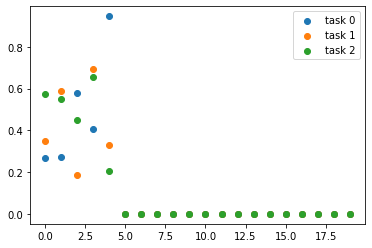

In [155]:
for r in range(n_tasks):
    plt.scatter(np.arange(n_features), causal_weights_per_task[r, :], label=('task %s' % r))
plt.legend()

In [156]:
X = np.zeros((n_samples, n_features))
y = np.zeros((n_samples, ))
start_idx = 0
end_idx = 0 
for r in range(n_tasks):
    end_idx += n_samples_per_task[r]
    X[start_idx:end_idx, :] = np.random.random(size=(n_samples_per_task[r], n_features))    
    y_tmp = np.dot(X[start_idx:end_idx, :], causal_weights_per_task[r]) + \
        epsilon * np.random.random(size=(n_samples_per_task[r], ))
    y[start_idx:end_idx] = np.where(y_tmp > np.mean(y_tmp), 1, 0)
    start_idx += n_samples_per_task[r]

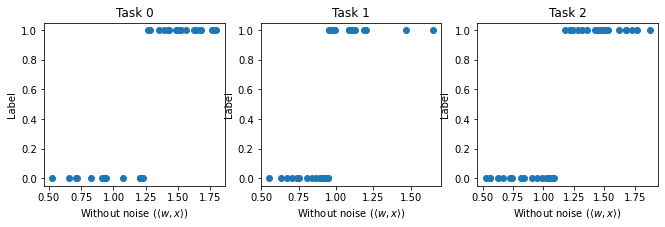

In [157]:
fig = plt.figure(figsize=(11, 3))
start_idx = 0
end_idx = 0 
for r in range(n_tasks):
    ax = plt.subplot(1, 3, (r+1))
    end_idx += n_samples_per_task[r]
    ax.scatter((np.dot(X[start_idx:end_idx, :], causal_weights_per_task[r])), y[start_idx:end_idx], label=('task %d' % r))
    start_idx += n_samples_per_task[r]
    t = plt.title("Task %d" % r)
    t = plt.xlabel(r"Without noise ($\langle w, x\rangle$)")
    t = plt.ylabel(r"Label")

## 2.2 Separate single-task l1-regularized logistic regressions on each task with sklearn
Let's consider our 3 tasks separately and run an l1-regularized logistic regression

In [158]:
from sklearn import linear_model

In [159]:
single_task_lasso_coefs = np.zeros(shape=(n_tasks, n_features))

In [160]:
from sklearn import model_selection

In [161]:
param_grid = {'C': np.logspace(-3, 2, num=100)}

In [162]:
lasso_gs = model_selection.GridSearchCV(linear_model.LogisticRegression(penalty='l1', solver='liblinear'), param_grid, scoring='f1')

In [163]:
single_task_lasso_coefs = np.zeros(shape=(n_tasks, n_features))

In [164]:
start_idx = 0
end_idx = 0 
for r in range(n_tasks):
    end_idx += n_samples_per_task[r]
    # fit lasso
    lasso_gs.fit(X[start_idx:end_idx, :], y[start_idx:end_idx])
    
    # obtain coefficients
    single_task_lasso_coefs[r, :] = lasso_gs.best_estimator_.coef_
    
    # obtain lambda
    print("Best lambda for task %d: %s" % (r, lasso_gs.best_params_))
    
    start_idx += n_samples_per_task[r]

Best lambda for task 0: {'C': 9.770099572992246}
Best lambda for task 1: {'C': 35.11191734215127}
Best lambda for task 2: {'C': 5.462277217684343}


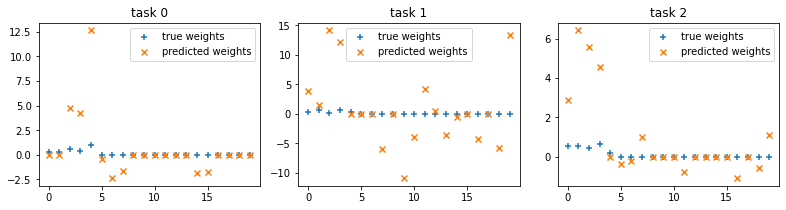

In [165]:
fig = plt.figure(figsize=(11, 3))
for r in range(n_tasks):
    # create a subplot in the (r+1) position of a 1x3 grid
    ax = fig.add_subplot(1, 3, (r+1))
    
    plt.scatter(np.arange(n_features), causal_weights_per_task[r, :], marker='+', label='true weights')
    
    plt.scatter(np.arange(n_features), single_task_lasso_coefs[r, :], marker='x', label='predicted weights')
    
    plt.legend()
    
    ax.set_title(('task %s' % r))
fig.tight_layout(pad=1.0)

__Remark:__ Note this does not work so well, the selected model doesn't have enough regularization...

## 2.3 Turning the problem into a sparse group lasso problem
Now we're ready to move to solving the 3 tasks together in a mulittask formulation.

### New design matrix

In [166]:
X_mt = np.zeros((n_samples, n_features*n_tasks))
start_idx = 0
end_idx = 0 
for r in range(n_tasks):
    end_idx += n_samples_per_task[r]
    
    X_mt[start_idx:end_idx, r*n_features:(r+1)*n_features] = X[start_idx:end_idx, :]
    
    start_idx += n_samples_per_task[r]

Let's look at this new design matrix and check it's block diagonal, with each data set forming one block.

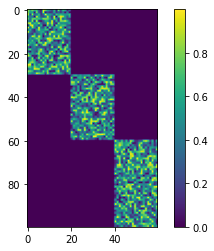

In [167]:
plt.imshow(X_mt, cmap='viridis', aspect='equal')
plt.colorbar()

### Group membership vector

In [168]:
groups = np.array([(1+x) for r in range(n_tasks) for x in np.arange(n_features)], dtype=np.int32)

## 2.4 Using spams

### Testing spams directly 

In [169]:
import spams

In [170]:
from scipy import sparse

In [171]:
X_sparse = sparse.csc_matrix(X_mt)

In [172]:
y_FA = np.asfortranarray(y.reshape(y.shape[0], 1))

In [173]:
w_initialization = np.zeros((X_sparse.shape[1], y_FA.shape[1]), order="F")

In [174]:
print(X_sparse.shape, y_FA.shape, w_initialization.shape, groups.shape)

(100, 60) (100, 1) (60, 1) (60,)


In [175]:
w = spams.fistaFlat(y_FA, X_sparse, W0=w_initialization, loss='logistic', regul='sparse-group-lasso-l2', 
                    groups=groups, lambda1=.005, lambda2=0.001)

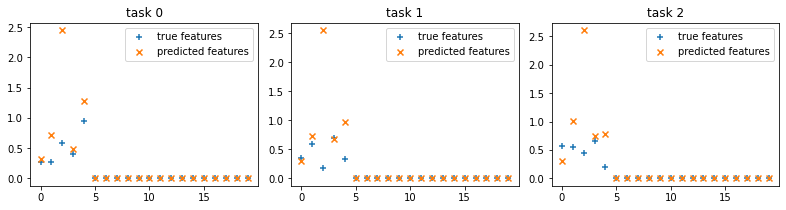

In [176]:
fig = plt.figure(figsize=(11, 3))
for r in range(n_tasks):
    # create a subplot in the (r+1) position of a 1x3 grid
    ax = fig.add_subplot(1, 3, (r+1))
    
    plt.scatter(np.arange(n_features), causal_weights_per_task[r, :], marker='+', label='true features')
    
    plt.scatter(np.arange(n_features), w[r*n_features:(r+1)*n_features], marker='x', label='predicted features')
    
    plt.legend()
    
    ax.set_title(('task %s' % r))
fig.tight_layout(pad=1.0)

### Turn it into a scikit-learn estimator
In order to use `sklearn.model_selection` we need to turn this into an estimator. 
Help from https://scikit-learn.org/stable/developers/develop.html and https://sklearn-template.readthedocs.io/en/latest/user_guide.html

In [177]:
from sklearn import base
from sklearn.utils import validation, multiclass

In [178]:
class MySpamsSparseGroupL1LogReg(base.BaseEstimator, base.ClassifierMixin):
    """
    This class implements a sparse group logistic regression that is fitted using SPAMS.
    """
    def __init__(self, lambda1=1., lambda2=0., groups=None):
        self.lambda1 = lambda1
        self.lambda2 = lambda2 
        self.groups = groups
                 
    def fit(self, X, y):     
        # Check that X and y have correct shape
        X, y = validation.check_X_y(X, y)
        
        # Store the classes seen during fit
        self.classes_ = multiclass.unique_labels(y)
        
        self.X_ = X
        self.y_ = y     
                
        # Fitting 
        X_sparse = sparse.csc_matrix(self.X_) #np.asfortranarray(self.X_) #
        y_asfa = np.asfortranarray(self.y_.reshape((self.y_.shape[0], 1)))
        w_init = np.zeros((X_sparse.shape[1], 1), order="F")
        
        w = spams.fistaFlat(y_asfa, X_sparse, W0=w_init, loss='square', regul='sparse-group-lasso-l2', groups=self.groups, 
                            lambda1=self.lambda1, lambda2=self.lambda2)
        
        self.coef_ = w.reshape((w.shape[0], ))

        # Return the classifier
        return self
    
    def predict_proba(self, X):
        # Check that fit has been called
        validation.check_is_fitted(self) 
        
        # Input validation
        X = validation.check_array(X)
        
        # Prediction
        return (1. / (1 + np.exp(-np.dot(X, self.coef_))))
    
    def predict(self, X):
        return np.where(self.predict_proba(X) > 0.5, 1, 0)

In [179]:
my_model = MySpamsSparseGroupL1LogReg(groups=groups, lambda1=0.001, lambda2=0.01)
my_model.fit(X_mt, y)
w = my_model.coef_

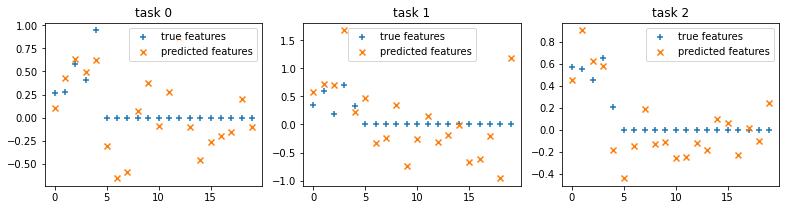

In [180]:
fig = plt.figure(figsize=(11, 3))
for r in range(n_tasks):
    # create a subplot in the (r+1) position of a 1x3 grid
    ax = fig.add_subplot(1, 3, (r+1))
    
    plt.scatter(np.arange(n_features), causal_weights_per_task[r, :], marker='+', label='true features')
    
    plt.scatter(np.arange(n_features), w[r*n_features:(r+1)*n_features], marker='x', label='predicted features')
    
    plt.legend()
    
    ax.set_title(('task %s' % r))
fig.tight_layout(pad=1.0)

In [181]:
param_grid = {'lambda1': np.logspace(-4, 1, num=30), 'lambda2': np.logspace(-4, 1, num=30)}

In [182]:
sglasso_gs = model_selection.GridSearchCV(MySpamsSparseGroupL1LogReg(groups=groups), param_grid, scoring='f1')

In [183]:
sglasso_gs.fit(X_mt, y)
    
# obtain coefficients
multi_task_lasso_coefs = sglasso_gs.best_estimator_.coef_
    
# obtain lambda
print("Best lambdas: %s" % sglasso_gs.best_params_)

Best lambdas: {'lambda1': 0.0001, 'lambda2': 0.02592943797404667}


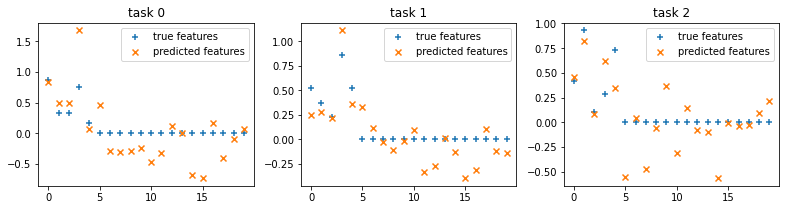

In [152]:
fig = plt.figure(figsize=(11, 3))
for r in range(n_tasks):
    # create a subplot in the (r+1) position of a 1x3 grid
    ax = fig.add_subplot(1, 3, (r+1))
    
    plt.scatter(np.arange(n_features), causal_weights_per_task[r, :], marker='+', label='true features')
    
    plt.scatter(np.arange(n_features), multi_task_lasso_coefs[r*n_features:(r+1)*n_features], marker='x', label='predicted features')
    
    plt.legend()
    
    ax.set_title(('task %s' % r))
fig.tight_layout(pad=1.0)